[데이콘] 신용카드 거래 데이터 시각화 대회
링크: https://dacon.io/competitions/official/42473/codeshare/429?page=1&dtype=recent

# 라이브러리 임포트 & 데이터 로드

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['axes.unicode_minus'] = False # 한글폰트 사용 시 마이너스 기호 깨짐 방지
from matplotlib import rc
rc('font', family='Malgun Gothic') # 한글도 가능하도록 폰트 설정
import seaborn as sns
import numpy as np
from collections import Counter
import os

In [ ]:
os.listdir()

In [2]:
train = pd.read_csv('dataset/train.csv')

# 컬럼 살펴보기

- store_id : 각 파일에서의 상점 고유 번호.
- date : 거래 일자
- time : 거래 시간
- card_id : 카드 번호의 hash 값
- amount : 매출액, 0보다 작은 음수는 거래 취소(환불), 단위 krw 아님, 할부개월수만큼 amount들어옴
- installments : 할부개월수. 일시불은 빈 문자열
- days_of_week : 요일, 월요일이 0, 일요일은 6
- holyday : 1이면 공휴일, 0이면 공휴일 아님

In [3]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0


# 데이터 가공하기

## Outlier 제거하기

이상치가 있을 만한 컬럼은 amount

violinplot을 이용해 데이터 분포범위를 확인

In [5]:
train['temp'] = 1

In [6]:
train.head()

,store_id,date,time,card_id,amount,installments,days_of_week,holyday,temp
0,0,2016-12-14,18:05:31,d297bba73f,5,NaN,2,0,1
1,0,2016-12-14,18:05:54,d297bba73f,-5,NaN,2,0,1
2,0,2016-12-19,12:42:31,0880849c05,144,NaN,0,0,1
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,NaN,0,0,1
4,0,2016-12-19,13:31:08,7ad237eed0,24,NaN,0,0,1


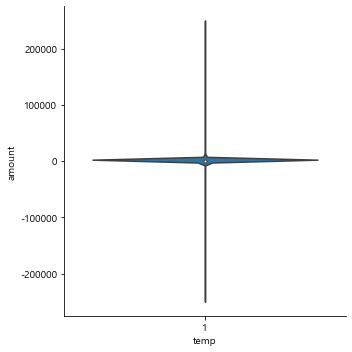

In [7]:
sns.catplot(data = train, x = 'temp', y = 'amount', kind = 'violin')

boxplot으로 이상치들 확인

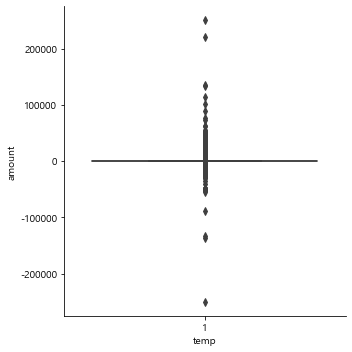

In [9]:
sns.catplot(data = train, x = 'temp', y = 'amount', kind = 'box')

amount의 평균을 확인해보면,145 정도로 최대/최소값 250000과는 괴리가 큼

In [10]:
train['amount'].describe()

count    3.362796e+06
mean     1.459623e+02
std      6.017306e+02
min     -2.500000e+05
25%      3.200000e+01
50%      7.500000e+01
75%      1.500000e+02
max      2.500000e+05
Name: amount, dtype: float64

numpy의 percentile을 이용해 데이터가 차지하는 비율을 확인
- 99%의 데이터는 1335이하, 98%의 데이터는 800이하의 값을 가짐

In [11]:
train_percentile = np.percentile(train['amount'], [98,99])
print(train_percentile)

[ 800. 1335.]


따라서, -1000 이상 1000 이하의 amount 값만 가지고 분석을 진행하려고 함

In [13]:
train = train.loc[(train['amount'] <= 1000) & (train['amount'] >= -1000)]

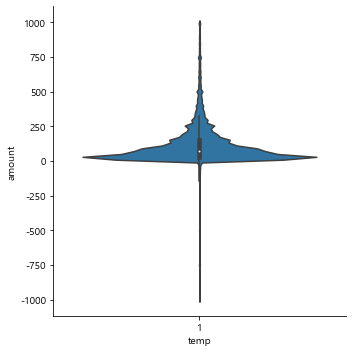

In [15]:
sns.catplot(data = train, x = 'temp', y = 'amount', kind = 'violin')

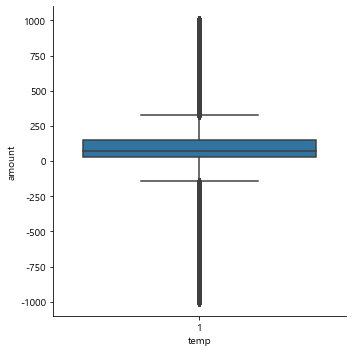

In [16]:
sns.catplot(data = train, x = 'temp', y = 'amount', kind = 'box')

## NULL값 채우기

train 데이터셋의 컬럼별 null값을 살펴보면, installments 컬럼에만 존재함을 알 수 있다. 해당 컬럼의 공백은 일시불을 의미하므로 모두 숫자 1을 넣어준다

In [17]:
train.isnull().sum()

store_id              0
date                  0
time                  0
card_id               0
amount                0
installments    3301841
days_of_week          0
holyday               0
temp                  0
dtype: int64

In [18]:
train.fillna(1, inplace = True)

C:\Users\new17\AppData\Local\Temp\ipykernel_8956\913436155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.fillna(1, inplace = True)


In [19]:
train.isnull().sum()

store_id        0
date            0
time            0
card_id         0
amount          0
installments    0
days_of_week    0
holyday         0
temp            0
dtype: int64

## Total 컬럼은 생성하지 않음

# 데이터 분석

본격적인 데이터 분석에 앞서 column간의 상관관계를 알아본다

In [20]:
del train['temp']

In [21]:
train[train.columns].corr()

,store_id,amount,installments,days_of_week,holyday
store_id,1.000000,0.051269,0.005056,0.008302,0.004617
amount,0.051269,1.000000,0.135976,0.023797,0.007234
installments,0.005056,0.135976,1.000000,0.000178,0.001455
days_of_week,0.008302,0.023797,0.000178,1.000000,-0.098483
holyday,0.004617,0.007234,0.001455,-0.098483,1.000000


<AxesSubplot:title={'center':'columns corr'}>

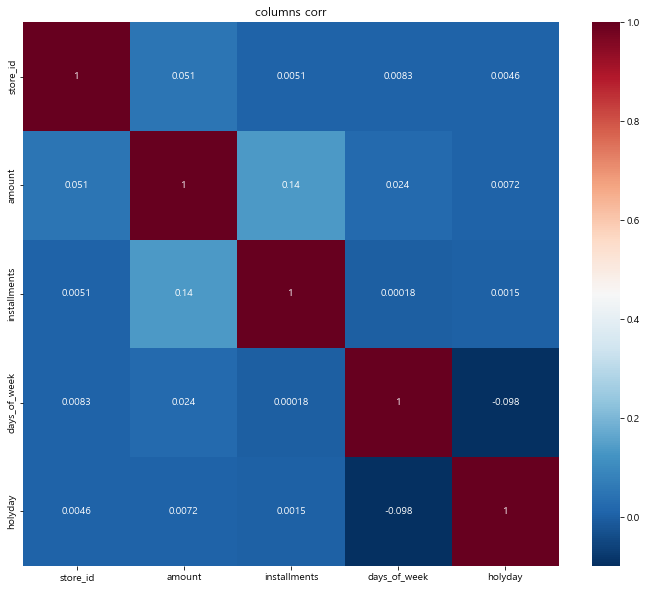

In [22]:
plt.figure(figsize = (12, 10))
plt.title('columns corr')
sns.heatmap(train[train.columns].corr(), cmap = 'RdBu_r', annot = True)

## store_id

<AxesSubplot:xlabel='count', ylabel='store_id'>

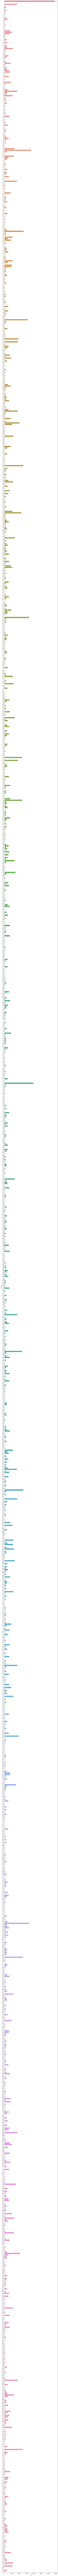

In [24]:
# store_id 별로 몇 번의 거래가 일어났는지 시각화
figure, ax = plt.subplots()
figure.set_size_inches(10, 500)
sns.countplot(data = train, y = 'store_id')

In [25]:
# 거래 기록 상위 N개 상점에 대해서 살펴본다

count_list = []
for i in range(1799):
    train_temp = train.loc[train["store_id"] == i]
    values = {"count" : train_temp.shape[0]} # train_temp df의 행 개수
    count_list.append(values) # 리스트에 딕셔너리 추가

In [27]:
count_list = pd.DataFrame.from_dict(count_list)


In [29]:
count_list = count_list.sort_values(by="count", ascending=False)
count_list.index.name = "store_id"

In [30]:
count_list.head(10)

,count
store_id,
0,68715
753,39217
105,35999
1342,33325
428,33281
221,31404
161,26108
1038,25694
323,25219


- 가장 많은 거래 기록이 있는 상점 번호는 0이며, 해당 기간 68715 건의 거래가 있었음

In [31]:
count_list.tail(10)

,count
store_id,
951,0
617,0
1600,0
601,0
255,0
11,0
1681,0
1216,0
506,0


- 0개의 거래 데이터를 가진 상점들이 있는 것으로 보임

In [33]:
# 0건의 거래 데이터를 가진 상점들이 얼마나 있을까?

count_list[count_list['count'] == 0].shape # 총 55개 존재

55

(다른 방법) 데이터셋에 없는 store_id가 존재하지 않는 것으로 가정한다면.

In [37]:
train.groupby('store_id').size().reset_index(name = '거래횟수').sort_values(by = '거래횟수', ascending = False).tail(10)

,store_id,거래횟수
1685,1740,1
964,991,1
670,689,1
1567,1618,1
1647,1701,1
1630,1684,1
593,608,1
708,727,1
1138,1170,1
297,304,1


## amount & installments

구매 금액과 할부 기간의 상관관계를 알아보자
- 분석 대상으로는 amount가 0 이상인 경우만 고려한다

In [38]:
amount_over0 = train[train['amount'] >= 0]

In [39]:
amount_over0

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
0,0,2016-12-14,18:05:31,d297bba73f,5,1.0,2,0
2,0,2016-12-19,12:42:31,0880849c05,144,1.0,0,0
3,0,2016-12-19,12:48:08,8b4f9e0e95,66,1.0,0,0
4,0,2016-12-19,13:31:08,7ad237eed0,24,1.0,0,0
5,0,2016-12-19,13:36:39,30b1422f77,44,1.0,0,0
...,...,...,...,...,...,...,...,...
3362791,1799,2018-07-19,17:58:31,e254bf70d9,600,1.0,3,0
3362792,1799,2018-07-19,18:54:34,8f41c89891,275,1.0,3,0
3362793,1799,2018-07-22,14:46:57,aeb64fe1fb,350,1.0,6,0
3362794,1799,2018-07-25,18:09:13,57932602d6,300,1.0,2,0


<AxesSubplot:xlabel='installments', ylabel='amount'>

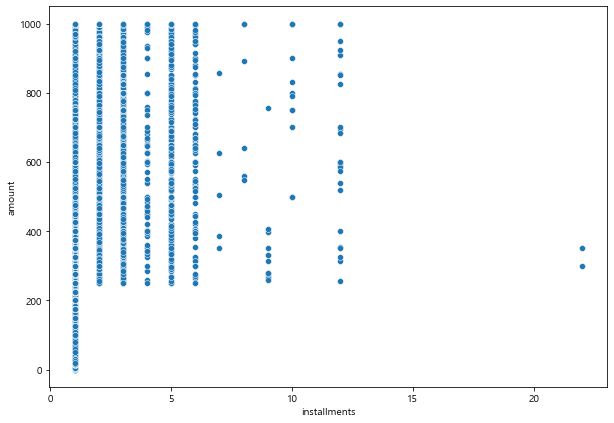

In [40]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
plt.figure(figsize=(10, 7))
sns.scatterplot(data=amount_over0, x="installments", y="amount", palette=cmap)

## amount & installments (추가분석)

### amount가 0이상인 데이터만 가지고 amount와 installments 상관계수를 구하면 조금 달라질까?

In [41]:
amount_over0[amount_over0.columns].corr()

,store_id,amount,installments,days_of_week,holyday
store_id,1.000000,0.047146,0.005359,0.008217,0.004715
amount,0.047146,1.000000,0.151309,0.023241,0.007373
installments,0.005359,0.151309,1.000000,0.000199,0.001312
days_of_week,0.008217,0.023241,0.000199,1.000000,-0.098686
holyday,0.004715,0.007373,0.001312,-0.098686,1.000000


<AxesSubplot:title={'center':'columns corr'}>

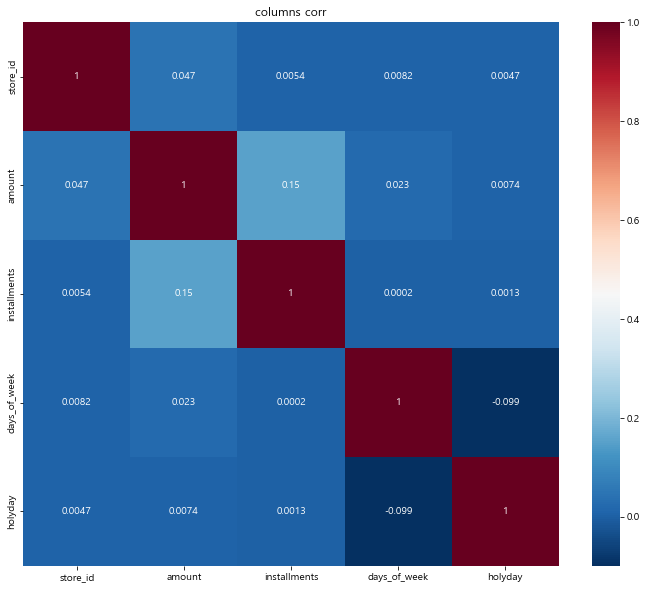

In [42]:
plt.figure(figsize = (12, 10))
plt.title('columns corr')
sns.heatmap(amount_over0[amount_over0.columns].corr(), cmap = 'RdBu_r', annot = True)

- 유의미한 차이가 발견되지 않음

### installments와 amount의 관계 더 살펴보기

In [43]:
installments_group = amount_over0.groupby('installments')

In [44]:
installments_group.size().reset_index(name = '거래횟수')

,installments,거래횟수
0,1.0,3270601
1,2.0,2719
2,3.0,5919
3,4.0,80
4,5.0,393
5,6.0,137
6,7.0,5
7,8.0,6
8,9.0,14
9,10.0,13


- 대부분의 거래가 일시불로 이뤄짐을 알 수 있음.

In [45]:
# 할부기간에 따라 결제 금액의 평균값을 살펴보면
installments_group['amount'].mean().reset_index(name = '결제 평균값')

,installments,결제 평균값
0,1.0,115.947463
1,2.0,485.928282
2,3.0,540.828687
3,4.0,648.275000
4,5.0,635.541985
5,6.0,671.131387
6,7.0,544.400000
7,8.0,773.166667
8,9.0,350.642857
9,10.0,809.384615


- 전반적으로 할부 기간이 올라갈수록 결제 평균값이 올라가는 경향을 보임. 다만, 9개월 할부, 22개월 할부에서는 오히려 많이 떨어짐

In [46]:
# 해당 할부 기간의 데이터를 조금 더 살펴보면
train[train['installments'].isin([9, 22])].sort_values(by = ["installments", "store_id", "amount"])

,store_id,date,time,card_id,amount,installments,days_of_week,holyday
290875,104,2018-03-30,20:16:36,d2b8fd5c59,276,9.0,4,0
290763,104,2018-03-25,15:49:33,fe47df477b,278,9.0,6,0
290944,104,2018-04-01,19:47:38,fdc1407062,397,9.0,6,0
292937,104,2018-06-24,17:10:19,72c846eb22,398,9.0,6,0
1705243,833,2018-04-02,19:54:25,8c1f81daed,405,9.0,0,0
1785426,911,2018-04-05,22:35:02,9fc9b4581a,270,9.0,3,0
1975481,1023,2017-01-09,17:35:40,f0b6e11ac0,260,9.0,0,0
1975368,1023,2016-12-20,20:52:15,7afcb650aa,265,9.0,1,0
1975414,1023,2016-12-30,20:08:06,e4902bebfd,280,9.0,4,0
1975361,1023,2016-12-19,19:20:10,58f3812b0f,315,9.0,0,0


- 평균 구매 단가가 300-400정도인 특정 매장에서 9개월, 22개월 무이자 할부 이벤트를 했을 가능성

In [47]:
# scatterplot에서 일시불이 아닌 데이터들이 특정 값 이상으로 분포하고 있음을 발견했다. 더 자세히 살펴보기 위해, 
installments_group['amount'].min().reset_index(name = '최소값')

,installments,최소값
0,1.0,0
1,2.0,250
2,3.0,250
3,4.0,250
4,5.0,250
5,6.0,250
6,7.0,350
7,8.0,548
8,9.0,260
9,10.0,500


- 할부가 가능한 최소 금액이 250이 아닐까?